In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=0.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x, min_val=0.0, max_val=1.0)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_ReLU1_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_chanels=5).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_s

### Copy weights

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,save_best=True, save_thr=90)

100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Epoch [1/100], Step [657/657], Loss: 2.3670, Accuracy: 0.1368
Accuracy of the network: 0.1612222222222222 Loss: 2.034222224925427


100%|██████████| 657/657 [03:21<00:00,  3.27it/s]


Epoch [2/100], Step [657/657], Loss: 2.0116, Accuracy: 0.1929
Accuracy of the network: 0.196 Loss: 2.0379950919895307


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [3/100], Step [657/657], Loss: 1.9828, Accuracy: 0.1989
Accuracy of the network: 0.19966666666666666 Loss: 1.9656265301907316


100%|██████████| 657/657 [03:20<00:00,  3.27it/s]


Epoch [4/100], Step [657/657], Loss: 1.9685, Accuracy: 0.2025
Accuracy of the network: 0.18633333333333332 Loss: 2.01302540217731


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [5/100], Step [657/657], Loss: 1.9357, Accuracy: 0.2071
Accuracy of the network: 0.30922222222222223 Loss: 1.796028547675897


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [6/100], Step [657/657], Loss: 1.4738, Accuracy: 0.4112
Accuracy of the network: 0.46944444444444444 Loss: 1.3916895173965615


100%|██████████| 657/657 [03:16<00:00,  3.35it/s]


Epoch [7/100], Step [657/657], Loss: 1.1066, Accuracy: 0.5783
Accuracy of the network: 0.6934444444444444 Loss: 0.8527679187608949


100%|██████████| 657/657 [03:33<00:00,  3.07it/s]


Epoch [8/100], Step [657/657], Loss: 0.8351, Accuracy: 0.6959
Accuracy of the network: 0.671 Loss: 0.9048873152293212


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [9/100], Step [657/657], Loss: 0.7405, Accuracy: 0.7364
Accuracy of the network: 0.7607777777777778 Loss: 0.708461102864421


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [10/100], Step [657/657], Loss: 0.6669, Accuracy: 0.7688
Accuracy of the network: 0.8465555555555555 Loss: 0.47823898610493815


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [11/100], Step [657/657], Loss: 0.6131, Accuracy: 0.7913
Accuracy of the network: 0.8652222222222222 Loss: 0.431892288016512


100%|██████████| 657/657 [03:37<00:00,  3.03it/s]


Epoch [12/100], Step [657/657], Loss: 0.5469, Accuracy: 0.8164
Accuracy of the network: 0.8444444444444444 Loss: 0.4888566216150074


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [13/100], Step [657/657], Loss: 0.5025, Accuracy: 0.8357
Accuracy of the network: 0.8745555555555555 Loss: 0.40986387944179226


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [14/100], Step [657/657], Loss: 0.4781, Accuracy: 0.8407
Accuracy of the network: 0.8815555555555555 Loss: 0.3884172575904968


100%|██████████| 657/657 [03:32<00:00,  3.10it/s]


Epoch [15/100], Step [657/657], Loss: 0.4491, Accuracy: 0.8532
Accuracy of the network: 0.8936666666666667 Loss: 0.35067583446172956


100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [16/100], Step [657/657], Loss: 0.4254, Accuracy: 0.8628
Accuracy of the network: 0.8622222222222222 Loss: 0.4204768992379202


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [17/100], Step [657/657], Loss: 0.4078, Accuracy: 0.8667
Accuracy of the network: 0.9005555555555556 Loss: 0.3267604442617149


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [18/100], Step [657/657], Loss: 0.3794, Accuracy: 0.8799
Accuracy of the network: 0.912 Loss: 0.30624202712841914


100%|██████████| 657/657 [03:31<00:00,  3.10it/s]


Epoch [19/100], Step [657/657], Loss: 0.3725, Accuracy: 0.8823
Accuracy of the network: 0.8876666666666667 Loss: 0.358675425674053


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [20/100], Step [657/657], Loss: 0.3453, Accuracy: 0.8903
Accuracy of the network: 0.9203333333333333 Loss: 0.27142889121322766


100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [21/100], Step [657/657], Loss: 0.3370, Accuracy: 0.8953
Accuracy of the network: 0.9137777777777778 Loss: 0.29627065154466226


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [22/100], Step [657/657], Loss: 0.3281, Accuracy: 0.8966
Accuracy of the network: 0.9126666666666666 Loss: 0.28107359416201605


100%|██████████| 657/657 [03:35<00:00,  3.06it/s]


Epoch [23/100], Step [657/657], Loss: 0.3108, Accuracy: 0.9024
Accuracy of the network: 0.9217777777777778 Loss: 0.26473983046962013


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [24/100], Step [657/657], Loss: 0.3041, Accuracy: 0.9043
Accuracy of the network: 0.9253333333333333 Loss: 0.25993069274522734


100%|██████████| 657/657 [03:33<00:00,  3.07it/s]


Epoch [25/100], Step [657/657], Loss: 0.2920, Accuracy: 0.9123
Accuracy of the network: 0.9344444444444444 Loss: 0.23437094068854836


100%|██████████| 657/657 [03:38<00:00,  3.01it/s]


Epoch [26/100], Step [657/657], Loss: 0.2883, Accuracy: 0.9116
Accuracy of the network: 0.929 Loss: 0.24947360929445173


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [27/100], Step [657/657], Loss: 0.2739, Accuracy: 0.9160
Accuracy of the network: 0.9277777777777778 Loss: 0.24379931538240285


100%|██████████| 657/657 [03:36<00:00,  3.04it/s]


Epoch [28/100], Step [657/657], Loss: 0.2637, Accuracy: 0.9225
Accuracy of the network: 0.9235555555555556 Loss: 0.24376408944685832


100%|██████████| 657/657 [03:38<00:00,  3.01it/s]


Epoch [29/100], Step [657/657], Loss: 0.2586, Accuracy: 0.9222
Accuracy of the network: 0.9344444444444444 Loss: 0.22357529023966044


100%|██████████| 657/657 [03:40<00:00,  2.98it/s]


Epoch [30/100], Step [657/657], Loss: 0.2489, Accuracy: 0.9250
Accuracy of the network: 0.9442222222222222 Loss: 0.20420491999239787


100%|██████████| 657/657 [03:36<00:00,  3.04it/s]


Epoch [31/100], Step [657/657], Loss: 0.2414, Accuracy: 0.9284
Accuracy of the network: 0.9412222222222222 Loss: 0.20390319019714567


100%|██████████| 657/657 [03:44<00:00,  2.92it/s]


Epoch [32/100], Step [657/657], Loss: 0.2369, Accuracy: 0.9300
Accuracy of the network: 0.9456666666666667 Loss: 0.19295979736386037


100%|██████████| 657/657 [03:42<00:00,  2.95it/s]


Epoch [33/100], Step [657/657], Loss: 0.2316, Accuracy: 0.9326
Accuracy of the network: 0.9381111111111111 Loss: 0.21080021696257675


100%|██████████| 657/657 [03:49<00:00,  2.86it/s]


Epoch [34/100], Step [657/657], Loss: 0.2224, Accuracy: 0.9351
Accuracy of the network: 0.9436666666666667 Loss: 0.1992727878325163


100%|██████████| 657/657 [03:50<00:00,  2.85it/s]


Epoch [35/100], Step [657/657], Loss: 0.2132, Accuracy: 0.9389
Accuracy of the network: 0.9475555555555556 Loss: 0.18921061337047013


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [36/100], Step [657/657], Loss: 0.2181, Accuracy: 0.9368
Accuracy of the network: 0.9466666666666667 Loss: 0.19203211569247094


100%|██████████| 657/657 [03:34<00:00,  3.07it/s]


Epoch [37/100], Step [657/657], Loss: 0.2051, Accuracy: 0.9410
Accuracy of the network: 0.9507777777777778 Loss: 0.1733054613020826


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [38/100], Step [657/657], Loss: 0.2045, Accuracy: 0.9417
Accuracy of the network: 0.9497777777777778 Loss: 0.177833764899707


100%|██████████| 657/657 [03:40<00:00,  2.98it/s]


Epoch [39/100], Step [657/657], Loss: 0.2040, Accuracy: 0.9420
Accuracy of the network: 0.9507777777777778 Loss: 0.17460569395875256


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [40/100], Step [657/657], Loss: 0.1963, Accuracy: 0.9446
Accuracy of the network: 0.9506666666666667 Loss: 0.17235379774414056


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [41/100], Step [657/657], Loss: 0.1913, Accuracy: 0.9465
Accuracy of the network: 0.9528888888888889 Loss: 0.16980515315415376


100%|██████████| 657/657 [03:33<00:00,  3.07it/s]


Epoch [42/100], Step [657/657], Loss: 0.1843, Accuracy: 0.9484
Accuracy of the network: 0.9526666666666667 Loss: 0.16921595465523978


100%|██████████| 657/657 [03:32<00:00,  3.10it/s]


Epoch [43/100], Step [657/657], Loss: 0.1904, Accuracy: 0.9458
Accuracy of the network: 0.951 Loss: 0.1701750497578095


100%|██████████| 657/657 [03:24<00:00,  3.22it/s]


Epoch [44/100], Step [657/657], Loss: 0.1848, Accuracy: 0.9479
Accuracy of the network: 0.9533333333333334 Loss: 0.1706980252836613


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [45/100], Step [657/657], Loss: 0.1842, Accuracy: 0.9468
Accuracy of the network: 0.955 Loss: 0.1629424105986213


100%|██████████| 657/657 [03:28<00:00,  3.16it/s]


Epoch [46/100], Step [657/657], Loss: 0.1783, Accuracy: 0.9497
Accuracy of the network: 0.9555555555555556 Loss: 0.15938700952217089


100%|██████████| 657/657 [03:25<00:00,  3.19it/s]


Epoch [47/100], Step [657/657], Loss: 0.1771, Accuracy: 0.9494
Accuracy of the network: 0.9545555555555556 Loss: 0.15868218051573485


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [48/100], Step [657/657], Loss: 0.1753, Accuracy: 0.9515
Accuracy of the network: 0.9564444444444444 Loss: 0.15945466421544552


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [49/100], Step [657/657], Loss: 0.1715, Accuracy: 0.9519
Accuracy of the network: 0.9557777777777777 Loss: 0.1560238420249934


100%|██████████| 657/657 [03:21<00:00,  3.27it/s]


Epoch [50/100], Step [657/657], Loss: 0.1696, Accuracy: 0.9528
Accuracy of the network: 0.9575555555555556 Loss: 0.15525115159809166


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [51/100], Step [657/657], Loss: 0.1633, Accuracy: 0.9540
Accuracy of the network: 0.9558888888888889 Loss: 0.15850546771118826


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [52/100], Step [657/657], Loss: 0.1650, Accuracy: 0.9569
Accuracy of the network: 0.9575555555555556 Loss: 0.15584963536325921


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [53/100], Step [657/657], Loss: 0.1690, Accuracy: 0.9524
Accuracy of the network: 0.9577777777777777 Loss: 0.15260847739822475


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [54/100], Step [657/657], Loss: 0.1626, Accuracy: 0.9543
Accuracy of the network: 0.9598888888888889 Loss: 0.14816451149312318


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [55/100], Step [657/657], Loss: 0.1635, Accuracy: 0.9539
Accuracy of the network: 0.9586666666666667 Loss: 0.1485611528475234


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [56/100], Step [657/657], Loss: 0.1606, Accuracy: 0.9564
Accuracy of the network: 0.9595555555555556 Loss: 0.14635104968060628


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [57/100], Step [657/657], Loss: 0.1604, Accuracy: 0.9578
Accuracy of the network: 0.9607777777777777 Loss: 0.1466049078838728


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [58/100], Step [657/657], Loss: 0.1586, Accuracy: 0.9564
Accuracy of the network: 0.9586666666666667 Loss: 0.14975085851227773


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [59/100], Step [657/657], Loss: 0.1597, Accuracy: 0.9547
Accuracy of the network: 0.9587777777777777 Loss: 0.1442741217382305


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [60/100], Step [657/657], Loss: 0.1576, Accuracy: 0.9578
Accuracy of the network: 0.9588888888888889 Loss: 0.14564440250793037


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [61/100], Step [657/657], Loss: 0.1578, Accuracy: 0.9568
Accuracy of the network: 0.9612222222222222 Loss: 0.14402161189189827


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [62/100], Step [657/657], Loss: 0.1555, Accuracy: 0.9585
Accuracy of the network: 0.9595555555555556 Loss: 0.1451043184014394


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [63/100], Step [657/657], Loss: 0.1561, Accuracy: 0.9580
Accuracy of the network: 0.9607777777777777 Loss: 0.14406771621673453


100%|██████████| 657/657 [03:18<00:00,  3.30it/s]


Epoch [64/100], Step [657/657], Loss: 0.1546, Accuracy: 0.9566
Accuracy of the network: 0.961 Loss: 0.14545756460874215


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [65/100], Step [657/657], Loss: 0.1575, Accuracy: 0.9572
Accuracy of the network: 0.9618888888888889 Loss: 0.1424289431541841


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [66/100], Step [657/657], Loss: 0.1547, Accuracy: 0.9574
Accuracy of the network: 0.9608888888888889 Loss: 0.14043010968767794


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [67/100], Step [657/657], Loss: 0.1537, Accuracy: 0.9566
Accuracy of the network: 0.9617777777777777 Loss: 0.14424063031502227


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [68/100], Step [657/657], Loss: 0.1539, Accuracy: 0.9574
Accuracy of the network: 0.9586666666666667 Loss: 0.14646177124628362


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [69/100], Step [657/657], Loss: 0.1529, Accuracy: 0.9566
Accuracy of the network: 0.9603333333333334 Loss: 0.14125429686317417


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [70/100], Step [657/657], Loss: 0.1518, Accuracy: 0.9594
Accuracy of the network: 0.9614444444444444 Loss: 0.14155074002234436


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [71/100], Step [657/657], Loss: 0.1508, Accuracy: 0.9583
Accuracy of the network: 0.9597777777777777 Loss: 0.144645524693402


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [72/100], Step [657/657], Loss: 0.1569, Accuracy: 0.9578
Accuracy of the network: 0.9605555555555556 Loss: 0.1403391719762738


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [73/100], Step [657/657], Loss: 0.1525, Accuracy: 0.9575
Accuracy of the network: 0.9621111111111111 Loss: 0.13894285404301704


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [74/100], Step [657/657], Loss: 0.1498, Accuracy: 0.9594
Accuracy of the network: 0.9602222222222222 Loss: 0.1421934686244485


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [75/100], Step [657/657], Loss: 0.1468, Accuracy: 0.9591
Accuracy of the network: 0.9611111111111111 Loss: 0.141857338897514


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [76/100], Step [657/657], Loss: 0.1520, Accuracy: 0.9581
Accuracy of the network: 0.9604444444444444 Loss: 0.14105975248104502


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [77/100], Step [657/657], Loss: 0.1536, Accuracy: 0.9587
Accuracy of the network: 0.9624444444444444 Loss: 0.13863643402801762


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [78/100], Step [657/657], Loss: 0.1508, Accuracy: 0.9586
Accuracy of the network: 0.9607777777777777 Loss: 0.14182769124072495


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [79/100], Step [657/657], Loss: 0.1515, Accuracy: 0.9570
Accuracy of the network: 0.9628888888888889 Loss: 0.13943308842176874


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [80/100], Step [657/657], Loss: 0.1503, Accuracy: 0.9586
Accuracy of the network: 0.9607777777777777 Loss: 0.1403467416208475


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [81/100], Step [657/657], Loss: 0.1507, Accuracy: 0.9589
Accuracy of the network: 0.9614444444444444 Loss: 0.1407311724776283


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [82/100], Step [657/657], Loss: 0.1507, Accuracy: 0.9587
Accuracy of the network: 0.9631111111111111 Loss: 0.13984988431003711


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [83/100], Step [657/657], Loss: 0.1479, Accuracy: 0.9587
Accuracy of the network: 0.9604444444444444 Loss: 0.14081919697238832


100%|██████████| 657/657 [03:09<00:00,  3.46it/s]


Epoch [84/100], Step [657/657], Loss: 0.1514, Accuracy: 0.9587
Accuracy of the network: 0.9624444444444444 Loss: 0.1377739611986681


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [85/100], Step [657/657], Loss: 0.1508, Accuracy: 0.9577
Accuracy of the network: 0.9606666666666667 Loss: 0.13826280953824943


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [86/100], Step [657/657], Loss: 0.1502, Accuracy: 0.9590
Accuracy of the network: 0.9617777777777777 Loss: 0.13871499390096953


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [87/100], Step [657/657], Loss: 0.1497, Accuracy: 0.9592
Accuracy of the network: 0.9635555555555556 Loss: 0.13769312337674994


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [88/100], Step [657/657], Loss: 0.1502, Accuracy: 0.9590
Accuracy of the network: 0.9622222222222222 Loss: 0.14048309328946026


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [89/100], Step [657/657], Loss: 0.1482, Accuracy: 0.9610
Accuracy of the network: 0.9611111111111111 Loss: 0.14389072155170407


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [90/100], Step [657/657], Loss: 0.1491, Accuracy: 0.9594
Accuracy of the network: 0.9617777777777777 Loss: 0.1358422356664289


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [91/100], Step [657/657], Loss: 0.1491, Accuracy: 0.9606
Accuracy of the network: 0.9634444444444444 Loss: 0.13863941525102508


100%|██████████| 657/657 [03:18<00:00,  3.31it/s]


Epoch [92/100], Step [657/657], Loss: 0.1509, Accuracy: 0.9588
Accuracy of the network: 0.9623333333333334 Loss: 0.13918422915517015


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [93/100], Step [657/657], Loss: 0.1476, Accuracy: 0.9592
Accuracy of the network: 0.9618888888888889 Loss: 0.1383017838159774


100%|██████████| 657/657 [03:19<00:00,  3.30it/s]


Epoch [94/100], Step [657/657], Loss: 0.1486, Accuracy: 0.9589
Accuracy of the network: 0.9618888888888889 Loss: 0.13893478725713196


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [95/100], Step [657/657], Loss: 0.1459, Accuracy: 0.9610
Accuracy of the network: 0.962 Loss: 0.14069247955839473


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [96/100], Step [657/657], Loss: 0.1496, Accuracy: 0.9575
Accuracy of the network: 0.9613333333333334 Loss: 0.14035881022717936


100%|██████████| 657/657 [03:20<00:00,  3.28it/s]


Epoch [97/100], Step [657/657], Loss: 0.1534, Accuracy: 0.9565
Accuracy of the network: 0.962 Loss: 0.13708270123849312


100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


Epoch [98/100], Step [657/657], Loss: 0.1472, Accuracy: 0.9597
Accuracy of the network: 0.9618888888888889 Loss: 0.14002753142267466


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [99/100], Step [657/657], Loss: 0.1525, Accuracy: 0.9579
Accuracy of the network: 0.9613333333333334 Loss: 0.13925445382318175


100%|██████████| 657/657 [02:24<00:00,  4.56it/s]


Epoch [100/100], Step [657/657], Loss: 0.1495, Accuracy: 0.9585
Accuracy of the network: 0.9621111111111111 Loss: 0.1381080614812408


In [10]:
torch.save(model, "best_resnet50_MINST-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")


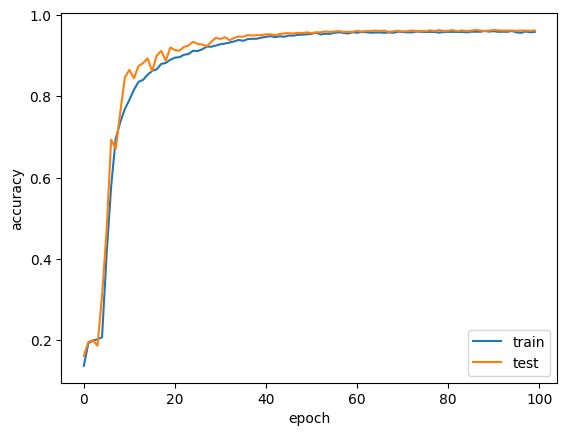

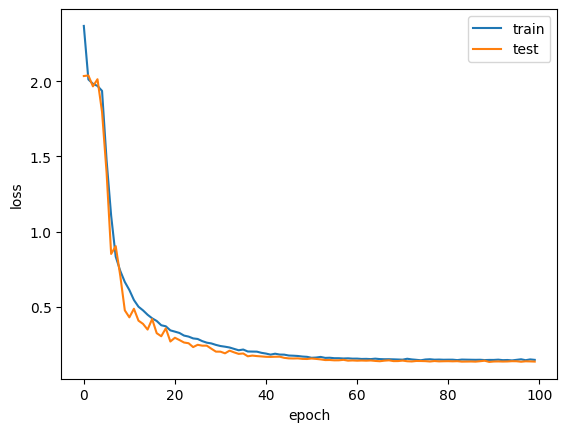

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.136762,0.161222,2.366967,2.034222
1,0.192905,0.196000,2.011594,2.037995
2,0.198857,0.199667,1.982762,1.965627
3,0.202476,0.186333,1.968548,2.013025
4,0.207095,0.309222,1.935684,1.796029
